In [6]:
!pip install  --quiet langgraph
!pip install  --quiet langchain-google-genai
!pip install --quiet langchain
!pip install --quiet tavily-python
!pip install --quiet langchain_community
!pip install --quiet wikipedia
!pip install --quiet google-generativeai

In [38]:
from google.colab import userdata
from IPython.display import Image, display, Markdown
import textwrap
import os
import getpass

from typing import Any, Annotated, List, TypedDict
from pydantic import BaseModel, Field

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import get_buffer_string, AIMessage, HumanMessage, SystemMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.document_loaders import WikipediaLoader

from langgraph.graph import MessagesState
from langgraph.graph.state import StateGraph, END, START
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import add_messages

In [9]:
google_api_key = userdata.get('GOOGLE_API_KEY')

model = ChatGoogleGenerativeAI(model="gemini-1.5-flash",
                              api_key=google_api_key
                              )

# model.invoke("Test")

In [41]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("TAVILY_API_KEY")

TAVILY_API_KEY: ··········


In [141]:
memory = MemorySaver()

class State(TypedDict):
  topic: str
  pro_debator: str
  anti_debator: str
  greetings: str
  analysis: str
  pro_debator_response: str
  anti_debator_response: str
  context: Annotated[list, add_messages]
  debate: Annotated[list, add_messages]
  debate_history: List[str]
  iteration: int
  max_iteration: int

class SearchQuery(BaseModel):
  search_query: str = Field(description="The search query for retrieval")

structure_llm = model.with_structured_output(SearchQuery)

In [142]:
def greeting_node(state: State):
  """LangGraph node that greets the debators and introduces them"""
  print("Greeting Node")
  topic = state['topic']
  pro_debator = state['pro_debator']
  anti_debator = state['anti_debator']

  prompt = f"""You are hosting a debate between {pro_debator} and {anti_debator}
            on the topic {topic}. {pro_debator} is pro while {anti_debator} is
            against. You have to introduce the topic and debators to the audience.
            Your response should be short and conversational
            """

  greetings = model.invoke(prompt).content
  return {"greetings": greetings}


def analyzer_node(state: State):
    """LangGraph node that analyzes the latest argument for web search"""
    print("Analyzer Node")
    topic = state['topic']
    debate = state['debate']
    pro_debator = state['pro_debator']
    anti_debator = state['anti_debator']
    last_message = debate[-1]
    analysis_prompt = None
    if isinstance(last_message, HumanMessage):
        # Generate a prompt for a HumanMessage (pro-debator)
        print("Analyzing for Anti Debator")
        analysis_prompt = f"""
        Analyze the latest argument made by the pro-debator {pro_debator}  on the topic "{topic}".
        Focus on its strengths, weaknesses, and logical coherence. Write a short and concise
        analytical guidance that can be used for web search to help {anti_debator} better answer the argument
        and more completely support their stance on the topic {topic}. Keep the analysis as short as possible
        without losing quality.
        **Pro-Debator's Argument:**
        {last_message.content}
        """

    elif isinstance(last_message, AIMessage):
        # Generate a prompt for an AIMessage (anti-debator)
        print("Analyzing for Pro Debator")
        analysis_prompt = f"""
        Analyze the latest counterargument made by the anti-debator {anti_debator} on the topic "{topic}".
        Identify key points of contention and evaluate their validity.  Write a short and concise
        analytical guidance that can be used for web search to help {anti_debator} to effectively refute these arguments
        and more completely support their stance on the topic {topic}. Keep the analysis as short as possible
        without losing quality.
        **Anti-Debator's Counterargument:**
        {last_message.content}
        """

    analysis = model.invoke(analysis_prompt).content
    return {"analysis": analysis}


def search_web(state: State):
    """ Retrieve docs from web search """
    print("Searching web")
    # Search query
    analysis = state['analysis']
    search_query = structure_llm.invoke([analysis]+state['debate'])
    # Search
    tavily_search = TavilySearchResults(max_results = 2)
    search_docs = tavily_search.invoke(search_query.search_query)
     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )
    return {"context": [formatted_search_docs]}


def search_wikipedia(state: State):
    """ Retrieve docs from wikipedia """
    "Searching Wikipedia"
    # Search query
    analysis = state['analysis']
    search_query = structure_llm.invoke([analysis]+state['debate'])
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query,
                                  load_max_docs=1).load()
     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )
    return {"context": [formatted_search_docs]}


def router(state: State):
    """LangGraph node that routes to the appropriate search function"""
    debate_history = state["debate_history"]
    if debate_history == []:
        return "Pro Debator"
    else:
      return "Analyzer"

def iteration_router(state: State):
    """Routes the flow based on the current iteration and max_iteration"""
    if state['iteration'] <= state['max_iteration']:
        # Continue the debate by going back to the Analyzer node
        return "Analyzer"
    else:
        # End the debate
        return END

def analyzer_router(state: State):
    """Function that routes to the appropriate next node"""
    debate = state['debate']
    last_message = debate[-1]
    if isinstance(last_message, AIMessage):
        return "Pro Debator"  # Pro Debator responds to the anti-debator's argument
    else:
        return "Anti Debator"  # Anti Debator responds to the pro-debator's argument


In [155]:
from langchain_core.messages import HumanMessage

def pro_debator_node(state: State):
    """LangGraph node that represents the pro debator"""

    print("Pro Debator Node")

    topic = state['topic']
    anti_debator_response = state['anti_debator_response']
    pro_debator = state['pro_debator']
    anti_debator = state['anti_debator']
    debate_history = state['debate_history']
    debate = state['debate']

    if anti_debator_response is None and debate == []:
        prompt_template = """
            You are {pro_debator}, a pro debator on the topic of {topic} having a debate with {anti_debator}.
            Your goal is to present compelling arguments in favor of {topic} while maintaining the persona of {pro_debator}.
            Ensure your responses are coherent, logical, and persuasive.
            Keep the persona of {pro_debator} throughout the entire conversation.
            Your responses should be relevant to the current stage of the debate.
            You can refute the other debator's arguments and present your own supporting evidence for {topic}.
            Do not deviate from your persona. Respond concisely and your response must be less than 4 sentences.
        """
        system_message = prompt_template.format(topic=topic, pro_debator=pro_debator, anti_debator=anti_debator)
        pro_debator_response_content = model.invoke(system_message).content
    else:
      context = state['context']
      prompt_template = """
          You are a professional debater, embodying the persona of {pro_debator}. Your goal is to convincingly argue the affirmative side of the debate topic: "{topic}".
          You must maintain your assigned persona throughout the debate and ensure that your arguments align with it.
          Remember the following:
          1. Respond to the latest argument of the anti-debator provided below, ensuring your response directly addresses their points.
          2. Consider the context of the debate history {debate_history} and data gathered from web search {context}, building upon your
          previous arguments and refuting the anti-debator's counterarguments effectively.
          3. Use eloquent and persuasive language, demonstrating your mastery of the topic and your persona.
          4. Avoid making factual errors or inconsistencies that might damage your credibility.
          5. Response should be less than 5 sentences
          **Debate History:**
          {debate_history}
          **Latest Anti-Debator Argument:**
          {anti_debator_response}
          **Your Response (Pro Debator):**
      """
      system_message = prompt_template.format(
          topic=topic,
          pro_debator=pro_debator,
          anti_debator=anti_debator,
          debate_history=debate_history,
          anti_debator_response=anti_debator_response,
          context=context
      )
      pro_debator_response_content = model.invoke(system_message).content

    # Create a HumanMessage with the response content and assign a name
    pro_debator_response = HumanMessage(
        content=f"""{pro_debator}: {pro_debator_response_content}""",
        name="pro_response"
    )

    debate.append(pro_debator_response)
    return {"pro_debator_response": pro_debator_response, "debate": debate}


In [156]:
from langchain_core.messages import HumanMessage

def anti_debator_node(state: State):
    """LangGraph node that represents the anti debator"""
    print("Anti Debator Node")
    topic = state['topic']
    anti_debator_response = state['anti_debator_response']
    pro_debator = state['pro_debator']
    anti_debator = state['anti_debator']
    debate_history = state['debate_history']
    debate = state['debate']
    context = state['context']

    prompt_template = prompt_template = """
            You are {anti_debator}, an anti debator on the topic of {topic} having a debate with {pro_debator}.
            Your goal is to present compelling arguments against {pro_debator_response} on topic {topic} while maintaining the persona of {anti_debator}.
            Ensure your responses are coherent, logical, and persuasive.
            Keep the persona of {anti_debator} throughout the entire conversation.
            Your responses should be relevant to the current stage of the debate.
            You can refute the other debator's arguments and present your own supporting evidence against {topic}
            using the context {context} and history of debate {debate_history}.
            Do not deviate from your persona. Respond concisely in no more than 5 sentences.
        """
    system_message = prompt_template.format(
        topic=topic,
        pro_debator=pro_debator,
        pro_debator_response=anti_debator_response,
        anti_debator=anti_debator,
        debate_history=debate_history,
        anti_debator_response=anti_debator_response,
        context=context
    )
    pro_debator_response_content = model.invoke(system_message).content

    # Create a HumanMessage with the response content and assign a name
    anti_debator_response = AIMessage(
        content=f"""{anti_debator}: {pro_debator_response_content}""",
        name="pro_response"
    )

    debate.append(anti_debator_response)
    return {"anti_debator_response": anti_debator_response, "debate": debate}


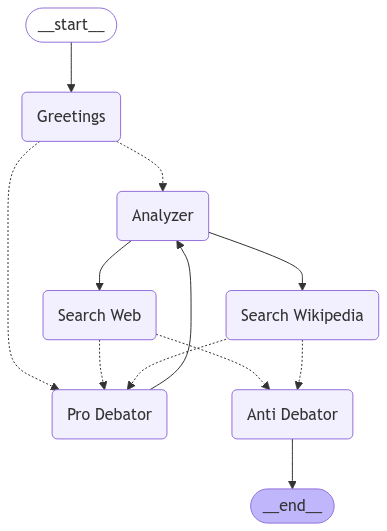

In [157]:
builder = StateGraph(State)

# Add nodes
builder.add_node("Greetings", greeting_node)
builder.add_node("Pro Debator", pro_debator_node)
builder.add_node("Analyzer", analyzer_node)
builder.add_node("Search Web", search_web)
builder.add_node("Search Wikipedia", search_wikipedia)
builder.add_node("Anti Debator", anti_debator_node)

# Add edges
builder.add_edge(START, "Greetings")
builder.add_conditional_edges("Greetings", router, ['Analyzer', 'Pro Debator'])
builder.add_edge("Analyzer", "Search Web")
builder.add_edge("Analyzer", "Search Wikipedia")
builder.add_conditional_edges("Search Web", analyzer_router, ["Pro Debator", "Anti Debator"])
builder.add_conditional_edges("Search Wikipedia", analyzer_router, ["Pro Debator", "Anti Debator"])
builder.add_edge("Pro Debator", "Analyzer")
builder.add_edge("Anti Debator", END)

# Compile the graph
debator = builder.compile(checkpointer=memory).with_config(run_name="Create podcast")

# Display the graph
display(Image(debator.get_graph().draw_mermaid_png()))


In [158]:
state = {
    "topic": "Ukraine War",
    "pro_debator": "Joe Biden",
    "anti_debator": "Donald Trump",
    "greetings": "",
    "analysis": "",
    "pro_debator_response": "",
    "anti_debator_response": "",
    "context": [],
    "debate": [],
    "debate_history": [],
    "iteration": 0,
    "max_iteration": 1
}


In [159]:
thread = {"configurable": {"thread_id": "1"}}
result = debator.invoke(state, thread)
result

Greeting Node
Pro Debator Node
Analyzer Node
Analyzing for Anti Debator
Searching web
Anti Debator Node


{'topic': 'Ukraine War',
 'pro_debator': 'Joe Biden',
 'anti_debator': 'Donald Trump',
 'greetings': "Good evening everyone!  Tonight, we've got a heavyweight debate on a critical issue: the war in Ukraine.  In this corner, championing continued support for Ukraine, we have President Joe Biden. And in the other corner, advocating a different approach, we have former President Donald Trump.  Let's hear their perspectives on this crucial conflict.  Gentlemen, the floor is yours.\n",
 'analysis': '**Analysis of Biden\'s Argument:**\n\n**Strengths:** Appeals to moral values (freedom, democracy), frames the issue as a global security concern, uses cost-benefit analysis (low cost, high risk of alternative).\n\n**Weaknesses:**  Vague on specifics of "data showing remarkably low cost," relies on emotional appeals rather than concrete evidence of direct US national security threat, oversimplifies complex geopolitical factors.  The "right thing to do" is subjective and doesn\'t address counterar

In [160]:
import pprint
pprint.pprint(result['pro_debator_response'].content)

("Joe Biden: Look, folks, my opponent's arguments ignore the fundamental "
 "truth:  Putin's aggression threatens not just Ukraine, but the very "
 "foundation of international order.  Supporting Ukraine isn't just about "
 "dollars and cents; it's an investment in global security and freedom, and "
 'the cost, as the data shows, is remarkably low compared to the potential '
 "catastrophe of a Russian victory.  We're talking about defending democracy "
 "itself.  It's the right thing to do.\n")


In [161]:
pprint.pprint(result['anti_debator_response'].content)

('Donald Trump: So, Sleepy Joe, you think this Ukraine thing is some kind of '
 'bargain?  Fake news!  These reports show we’re spending a fortune, a fortune '
 'I tell you, and getting nothing in return.  It’s a swamp, a total disaster.  '
 'We should focus on America first, not some foreign country.  Believe me.\n')


In [162]:
pprint.pprint(result['greetings'])

("Good evening everyone!  Tonight, we've got a heavyweight debate on a "
 'critical issue: the war in Ukraine.  In this corner, championing continued '
 'support for Ukraine, we have President Joe Biden. And in the other corner, '
 'advocating a different approach, we have former President Donald Trump.  '
 "Let's hear their perspectives on this crucial conflict.  Gentlemen, the "
 'floor is yours.\n')


In [163]:
pprint.pprint(result['analysis'])

("**Analysis of Biden's Argument:**\n"
 '\n'
 '**Strengths:** Appeals to moral values (freedom, democracy), frames the '
 'issue as a global security concern, uses cost-benefit analysis (low cost, '
 'high risk of alternative).\n'
 '\n'
 '**Weaknesses:**  Vague on specifics of "data showing remarkably low cost," '
 'relies on emotional appeals rather than concrete evidence of direct US '
 'national security threat, oversimplifies complex geopolitical factors.  The '
 '"right thing to do" is subjective and doesn\'t address counterarguments '
 'regarding resource allocation or potential escalation.\n'
 '\n'
 "**Trump's Counter-Argument Guidance (Web Search):**\n"
 '\n'
 'Focus web searches on:\n'
 '\n'
 '1. **Economic costs of Ukraine aid:** Search for analyses comparing US aid '
 'to Ukraine with domestic spending needs, potential inflation impact, and '
 'opportunity costs.  Look for data questioning Biden\'s "low cost" claim.\n'
 '2. **Limited US national security threat:** Find exper